In [1]:
import scanpy as sc
import anndata as ad
import scarches as sca
import datetime

train_set = sc.read_h5ad("/home/wyh/liver_atlas/data/Guilliams2022/Guilliams2022_plot_V2.h5ad")
# sc.pp.subsample(train_set, n_obs = 5000)
train_set

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
 captum (see https://github.com/pytorch/captum).


AnnData object with n_obs × n_vars = 167598 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'labels', 'UMAP_1', 'UMAP_2', 'cluster', 'annot', 'sample', 'cell', 'digest', 'typeSample', 'original_name', 'batch', 'level1', 'leiden', 'Sample_ID', 'barcodes', 'Patient_ID', 'Sample_link', 'Sample_status', 'Seq_tech', 'GEO_accession', 'Sample.Number.Flow', 'Biopsy.used.for.', 'Gender', 'Age', 'Weight', 'Height', 'Reason.for.hospitalization', 'Procedure', 'Concomitant.medication', 'Concomitant.disorders.operations', 'Alcohol.intake', 'Steatosis', 'Fibrosis', 'Disease', 'Fibrotic_status', 'Author'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Patient_ID_colors', 'batch_colors', 'hvg', 'leiden', 'level1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [2]:
train_set.obs['Sample_ID']

barcodes
Guilliams2022/AAACCTGTCAGGATCT-1     CISE06
Guilliams2022/AAACGGGAGCACAGGT-1     CISE06
Guilliams2022/AAACGGGAGTGTGGCA-1     CISE06
Guilliams2022/AAACGGGAGTTAGGTA-1     CISE06
Guilliams2022/AAACGGGCACCAGATT-1     CISE06
                                      ...  
Guilliams2022/TTTACCAAGAGAGGTA-41     CS171
Guilliams2022/TTTACCAGTATCGAAA-41     CS171
Guilliams2022/TTTCCTCGTGAGGCAT-41     CS171
Guilliams2022/TTTCGATTCGATAACC-41     CS171
Guilliams2022/TTTGGAGTCCACTGGG-41     CS171
Name: Sample_ID, Length: 167598, dtype: category
Categories (38, object): ['ABU8', 'CISE06', 'CISE07', 'CISE08', ..., 'CS167', 'CS169', 'CS170', 'CS171']

In [3]:
import numpy as np
np.max(train_set.X)

8.626279

In [4]:
def scvi_train(adata):
    start=datetime.datetime.now()
    adata.raw = adata
    sc.pp.highly_variable_genes(
        adata,
        flavor="seurat_v3",
        n_top_genes=2000,
        layer="counts",
        batch_key="batch",
        subset=True,
        span=0.5
    )
    sca.models.SCVI.setup_anndata(
        adata, 
        layer="counts", 
        batch_key="sample", 
        labels_key="level1"
    )
    vae = sca.models.SCVI(
        adata,
        n_layers=2,
        n_latent=30,
        gene_likelihood="nb",
        encode_covariates=False,
        deeply_inject_covariates=True,
        use_layer_norm="both",
        use_batch_norm="none",
    )
    vae.train()
    return vae

#     lvae = sca.models.SCANVI.from_scvi_model(
#         vae,
#         unlabeled_category="Unknown",
#     )
#     lvae.train(max_epochs=20, n_samples_per_label=100)
#     ref_path = '../../model/scarches_model_new/'
#     end=datetime.datetime.now()
#     lvae.save(ref_path, overwrite=True)
#     print("scanvi train(Seconds):", end-start)
#     return lvae

vae = scvi_train(adata=train_set)
vae.save('scvi_ref_model_sample/', overwrite=True)

INFO     Using batches from adata.obs["sample"]                                              


INFO:scvi.data._anndata:Using batches from adata.obs["sample"]


INFO     Using labels from adata.obs["level1"]                                               


INFO:scvi.data._anndata:Using labels from adata.obs["level1"]


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 167598 cells, 2000 vars, 38       
         batches, 8 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


INFO:scvi.data._anndata:Successfully registered anndata object containing 167598 cells, 2000 vars, 38 batches, 8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1/48:   0%|                                        | 0/48 [00:00<?, ?it/s]

/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/wyh/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 48/48: 100%|███████████| 48/48 [14:59<00:00, 18.74s/it, loss=417, v_num=1]


In [5]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = train_set.obs["level1"].tolist()
reference_latent.obs["batch"] = train_set.obs["batch"].tolist()
reference_latent.write("./reference_latent_sample.h5ad")

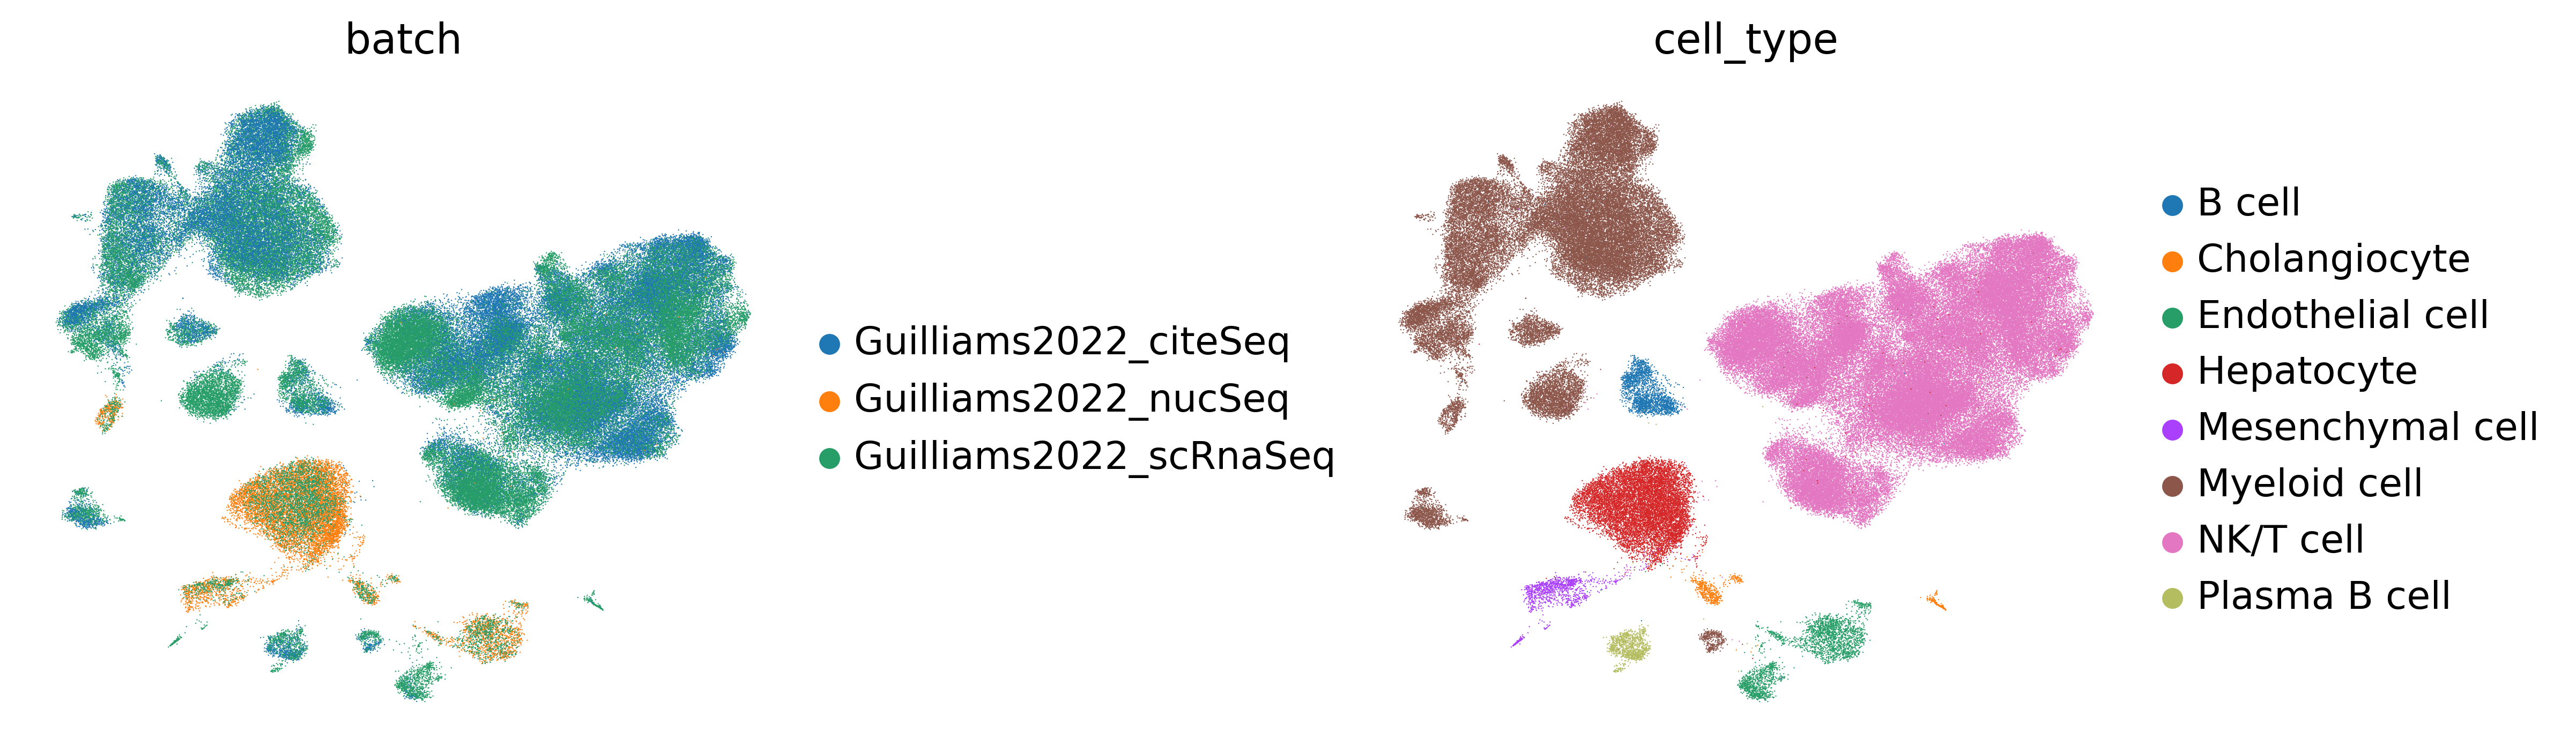

In [6]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

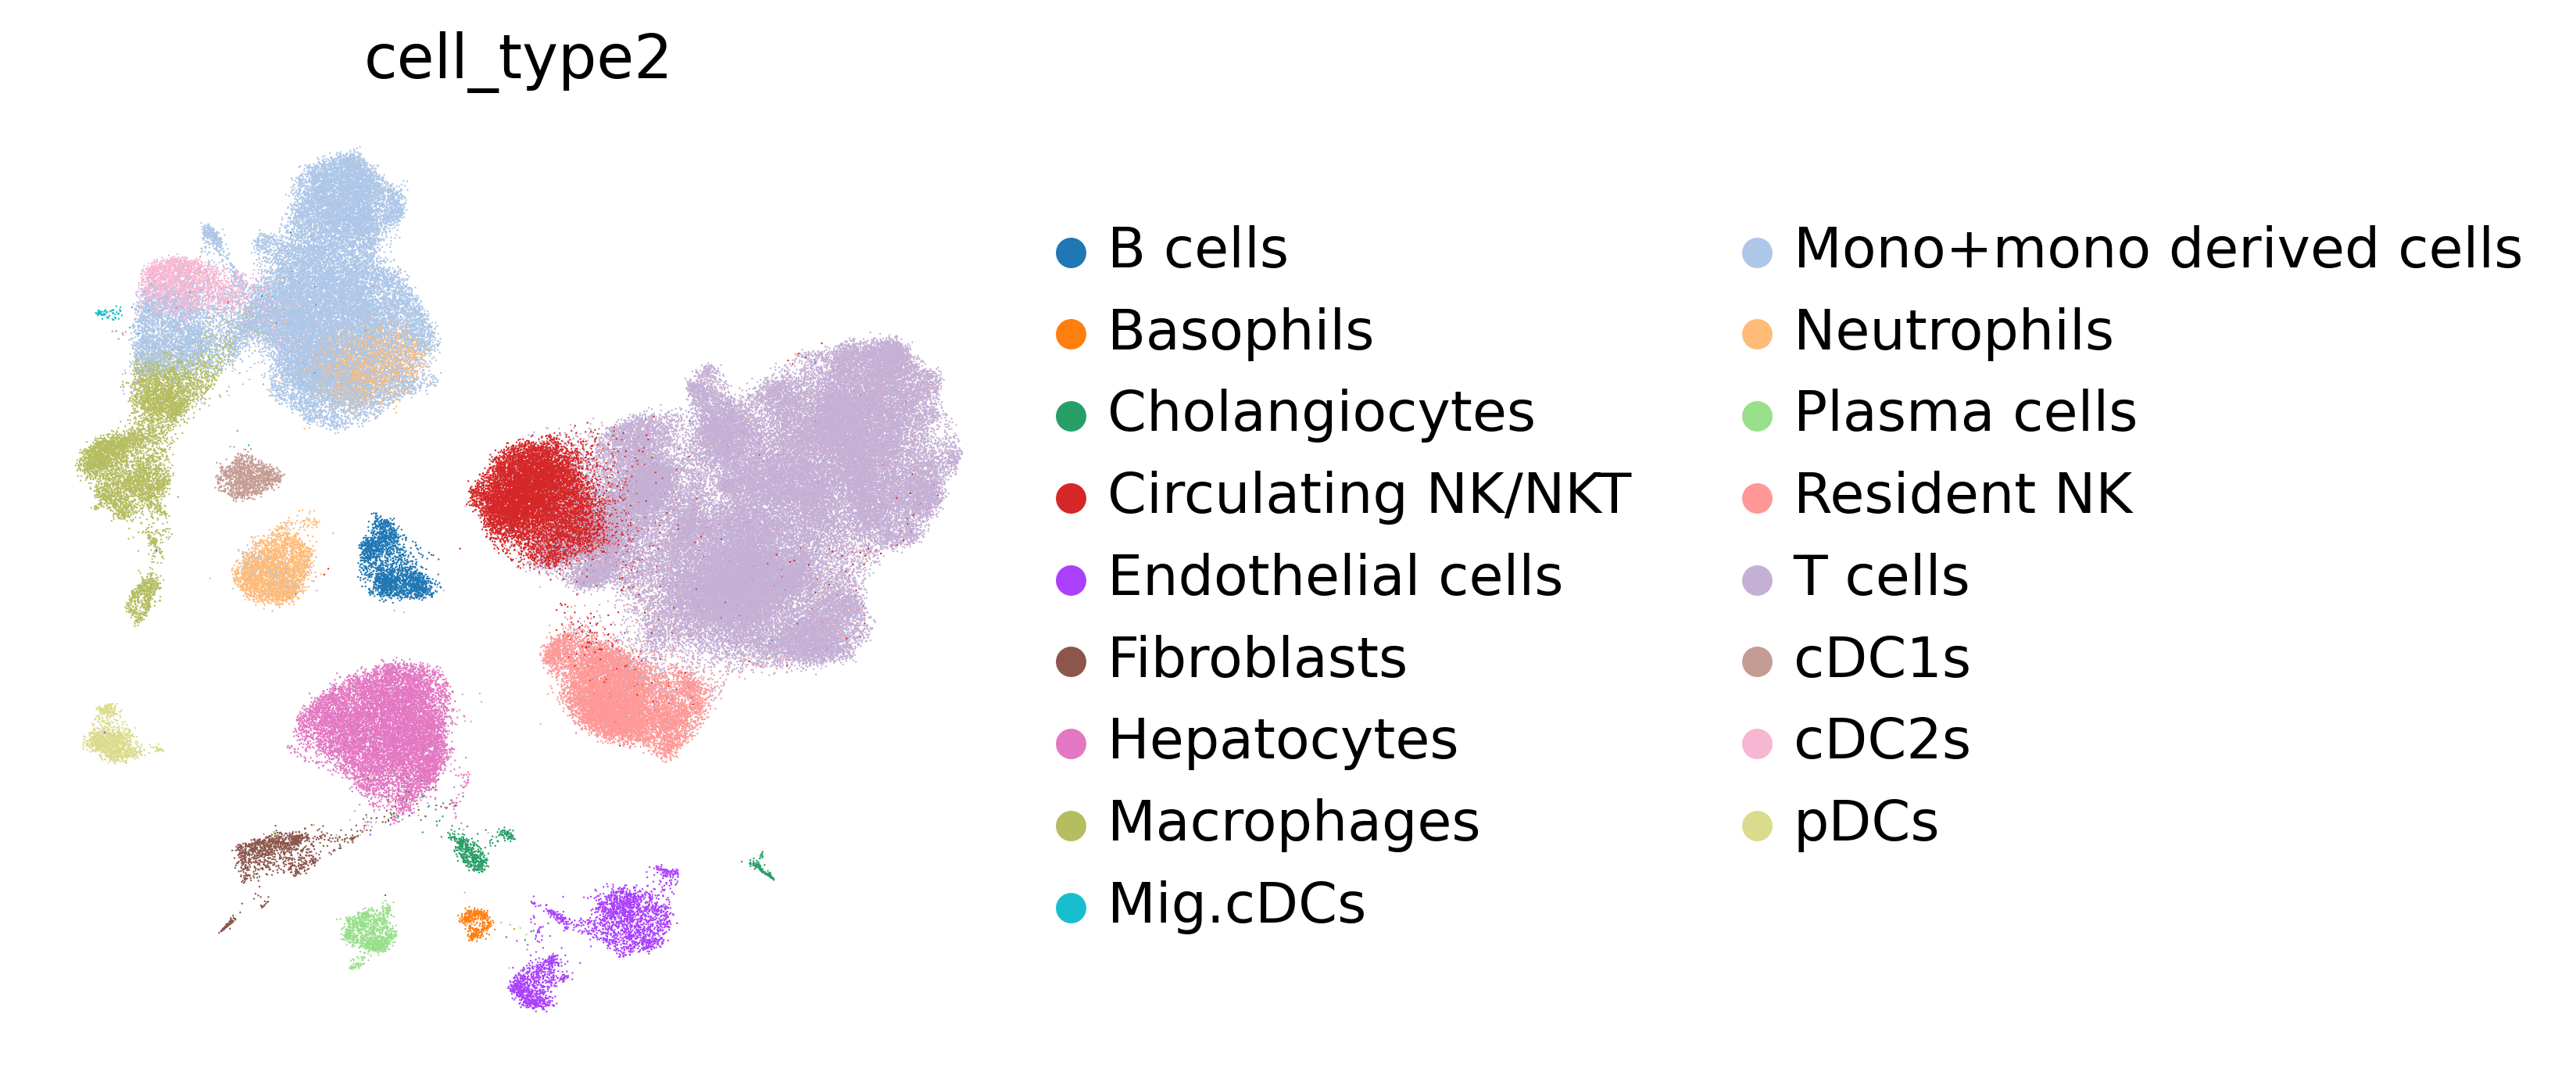

In [7]:
reference_latent.obs["cell_type2"] = train_set.obs["original_name"].tolist()
sc.pl.umap(reference_latent,
           color=['cell_type2'],
           frameon=False,
           wspace=0.6,
           )

In [8]:
vae.module.decoder

DecoderSCVI(
  (px_decoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=68, out_features=128, bias=True)
        (1): None
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
        (3): ReLU()
        (4): None
      )
      (Layer 1): Sequential(
        (0): Linear(in_features=166, out_features=128, bias=True)
        (1): None
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
        (3): ReLU()
        (4): None
      )
    )
  )
  (px_scale_decoder): Sequential(
    (0): Linear(in_features=128, out_features=2000, bias=True)
    (1): Softmax(dim=-1)
  )
  (px_r_decoder): Linear(in_features=128, out_features=2000, bias=True)
  (px_dropout_decoder): Linear(in_features=128, out_features=2000, bias=True)
)

In [4]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = train_set.obs["level1"].tolist()
reference_latent.obs["batch"] = train_set.obs["batch"].tolist()
reference_latent.write("./reference_latent.h5ad")

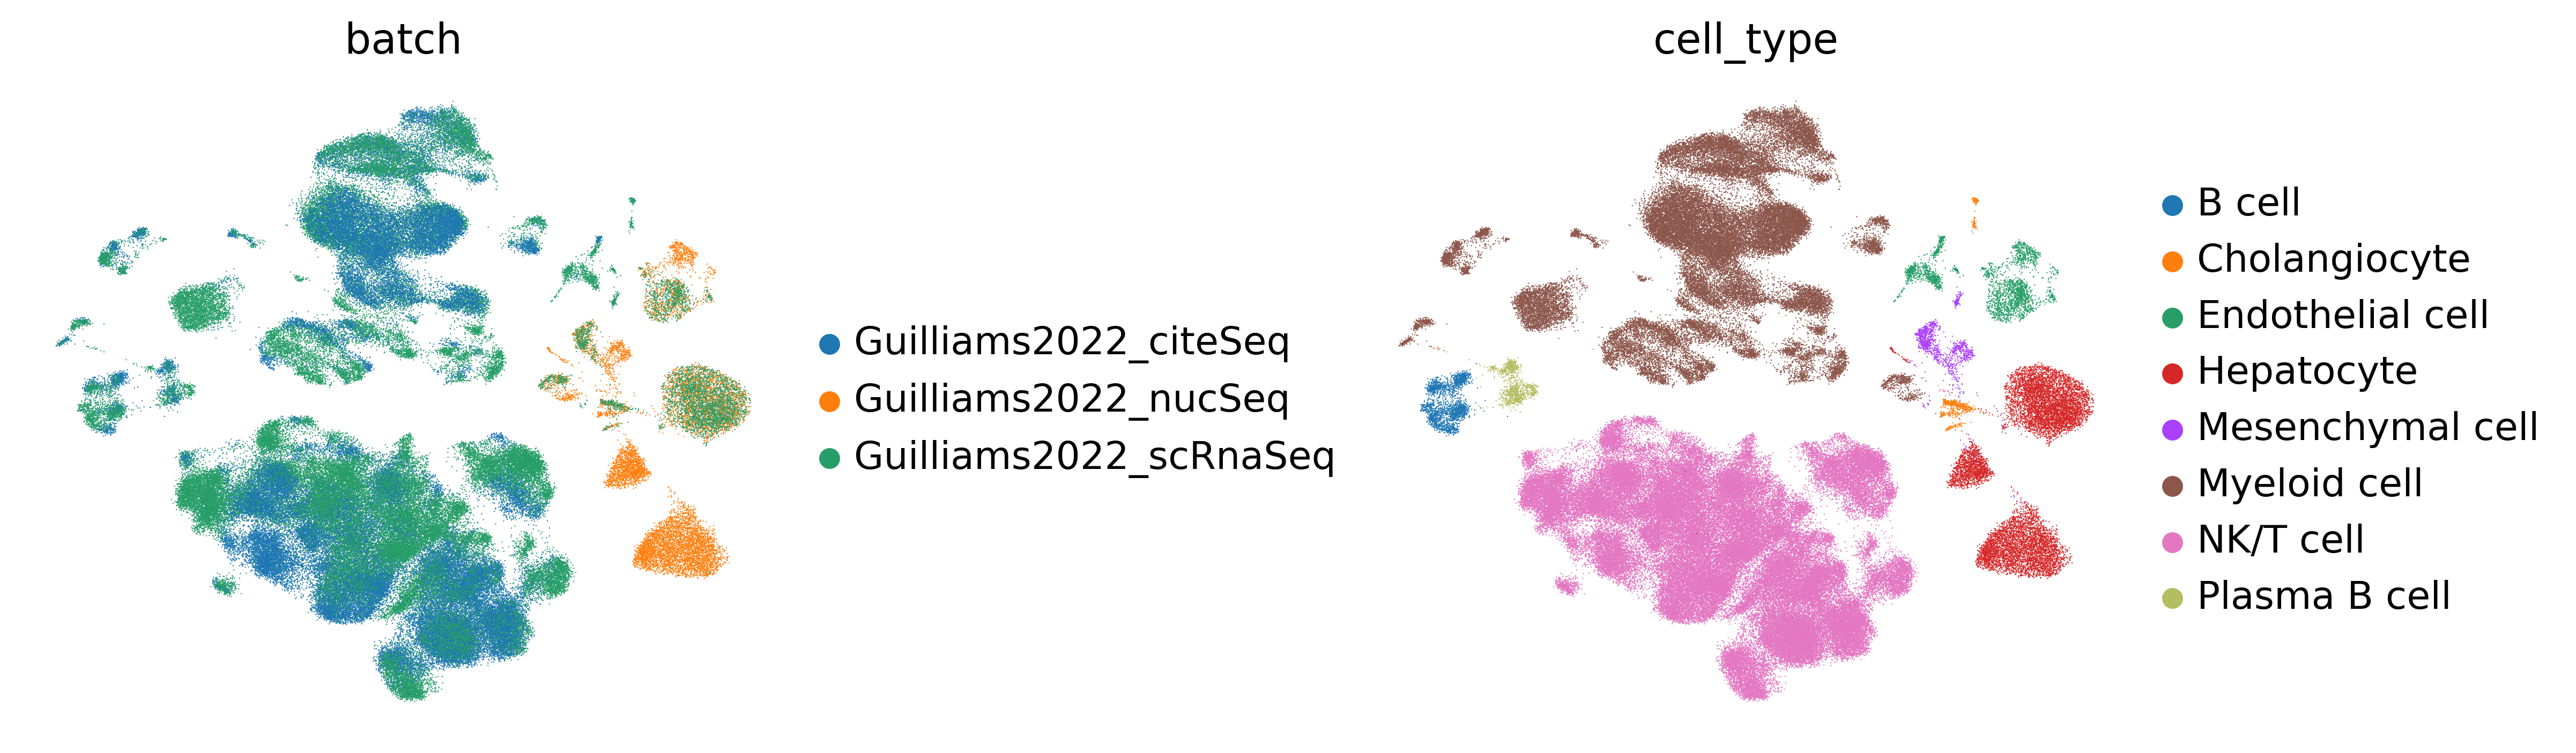

In [5]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

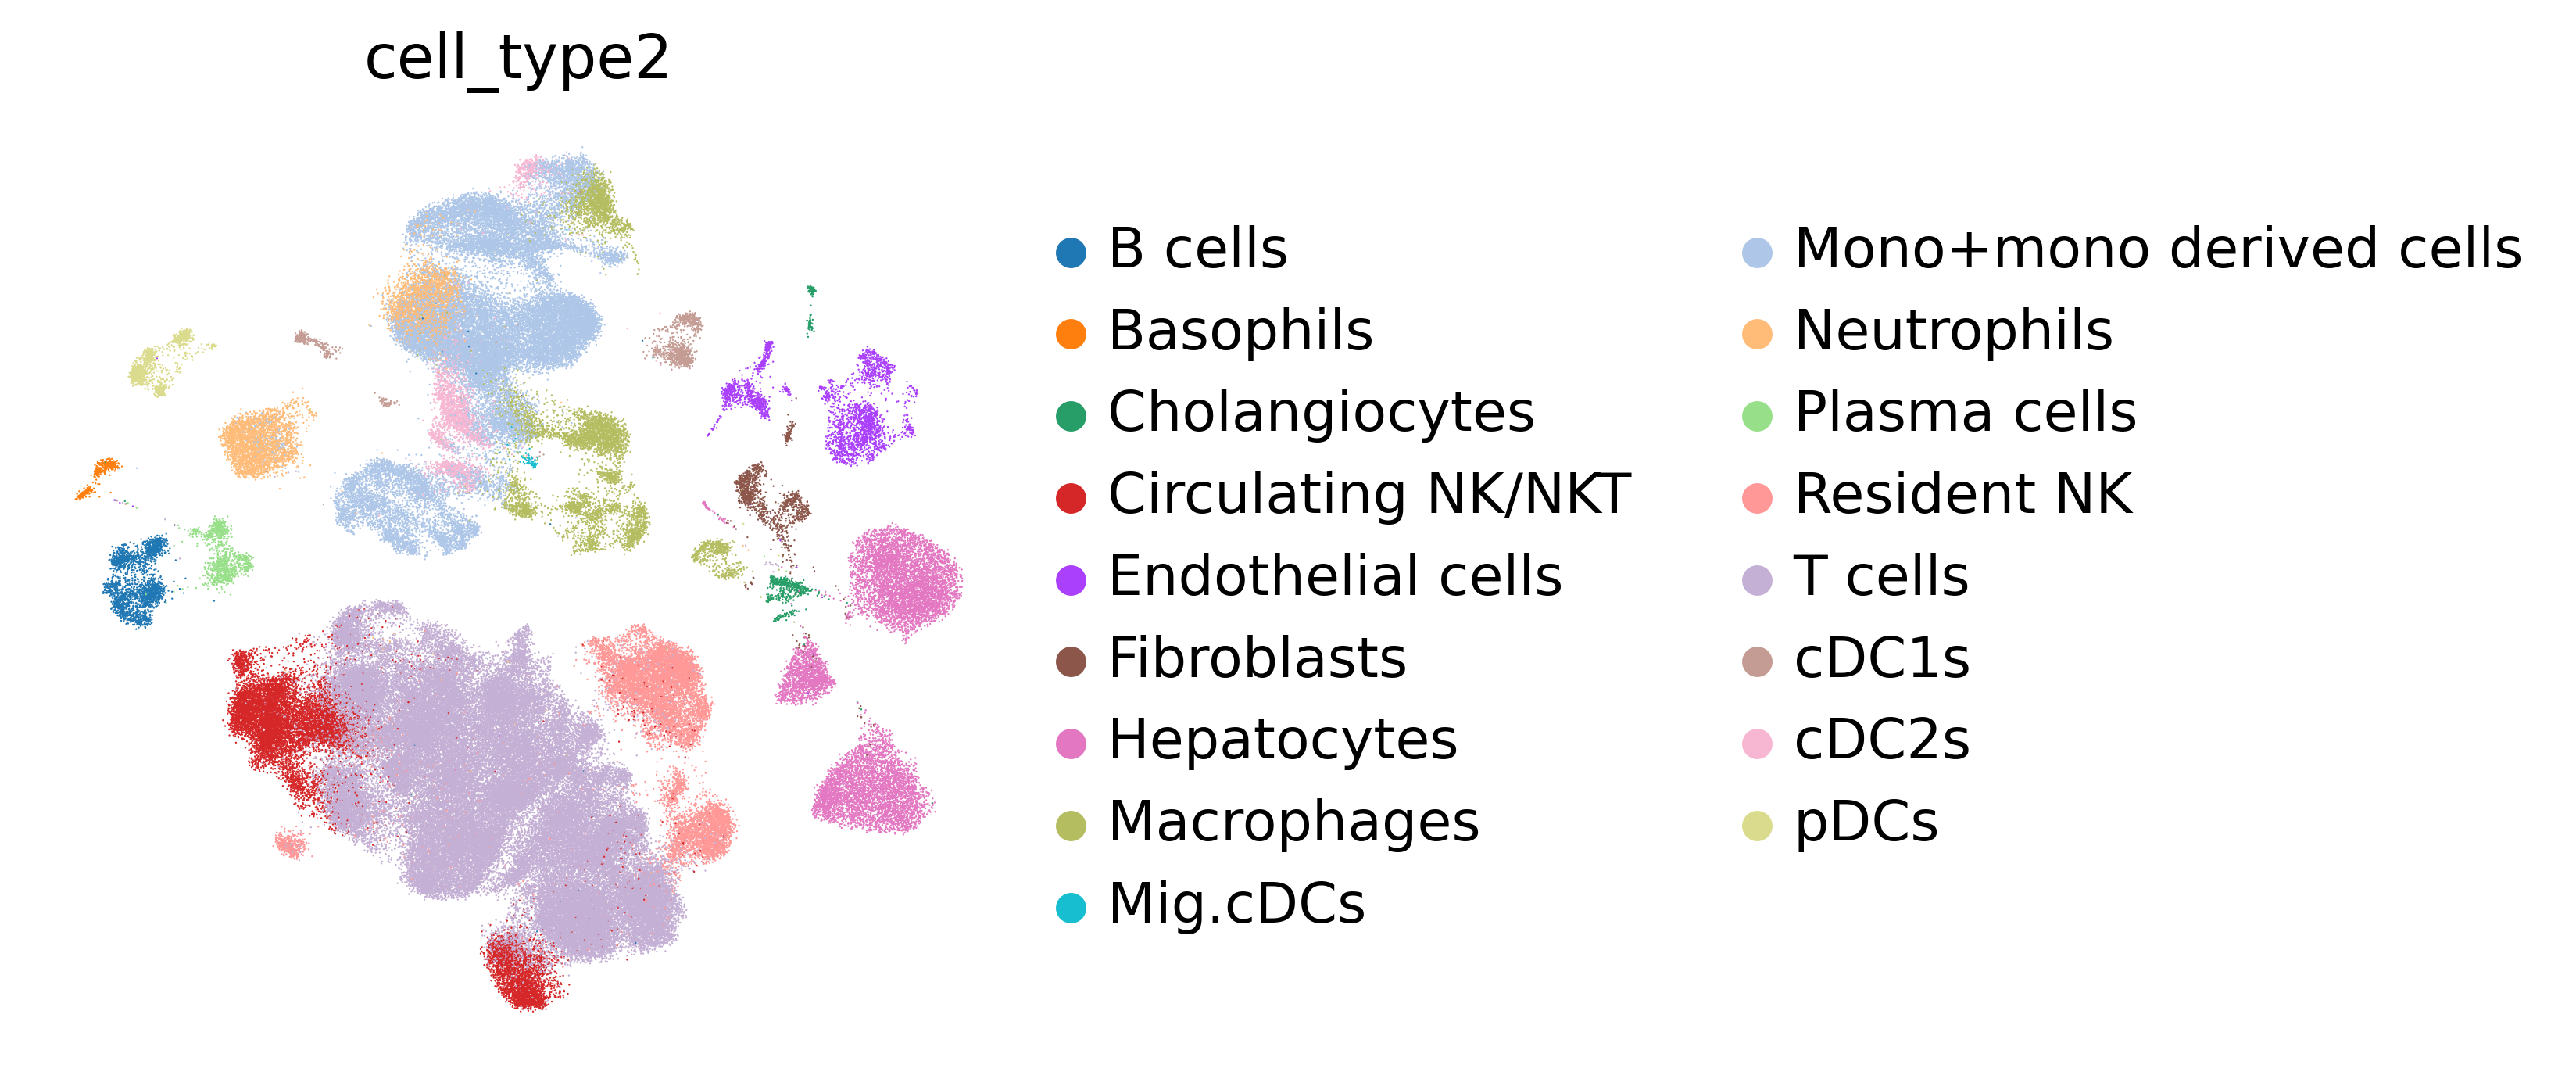

In [9]:
reference_latent.obs["cell_type2"] = train_set.obs["original_name"].tolist()
sc.pl.umap(reference_latent,
           color=['cell_type2'],
           frameon=False,
           wspace=0.6,
           )

In [23]:
vae.module

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=2000, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=30, bias=True)
    (var_encoder): Linear(in_features=128, out_features=30, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=2000, out_features=128, bias=True)
          (1): None
          (2): LayerN

In [179]:
import scvi
scvi.data.view_anndata_setup(model.adata)

/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


Anndata setup with scvi-tools version 0.14.6.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 10372 │
│             Vars             │ 2000  │
│            Labels            │   9   │
│           Batches            │   4   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │  adata.layers['counts']   │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['level1'] │      B cell      │          0          │
│                     │  Cholangiocyte   │          1          │
│                     │ Endothelial cell │          2          │
│                     │    Hepatocyte    │          3          │
│                     │ Mesenchymal cell │          4          │
│                     │   Myeloid cell   │          5          │
│                     │    NK/T cell     │          6          │
│                     │  Plasma B cell   │          7          │
│                     │     Unknown      │          8          │
└─────────────────────┴──────────────────┴─────────────────────┘

                          Batch Categories                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │ Guilliams2022_citeSeq  │          0          │
│                    │  Guilliams2022_nucSeq  │          1          │
│                    │ Guilliams2022_scRnaSeq │          2          │
│                    │      Aizarani2019      │          3          │
└────────────────────┴────────────────────────┴─────────────────────┘

In [175]:
n=1000
inference_output = model.module.inference(
    torch.tensor(query_adata.X[:n,:].toarray()), 
#     torch.tensor(train_set.layers['counts'][:n,:].toarray()), 
    batch_index=torch.full((n, 1), 3)
)
inference_output

{'z': tensor([[ 0.792, -0.913,  0.023, -0.539, -1.045, -0.479,  1.390,  ..., -0.061,
           3.051,  1.121,  0.944, -0.685, -1.045, -1.270],
         [-0.126, -0.182, -0.960, -2.082, -1.045,  0.180,  0.322,  ...,  1.533,
           0.662,  1.273, -0.487, -0.099, -1.055, -0.180],
         [ 1.200, -1.246,  0.790,  0.736, -0.473, -0.504,  1.078,  ...,  1.288,
          -0.412,  1.175,  0.478, -0.471, -1.674, -1.597],
         [-0.253, -0.171,  0.836,  1.267, -0.598, -0.490,  1.190,  ...,  0.690,
          -1.668,  1.213, -1.727, -2.049, -0.219,  0.148],
         [-0.919,  1.110,  0.360,  1.121, -0.445, -0.576, -0.016,  ..., -0.121,
           2.016, -1.211, -0.292, -0.936, -1.709, -0.086],
         [-1.179, -0.653, -0.741, -0.062, -0.595, -0.567,  1.711,  ...,  1.365,
          -0.885, -0.409,  0.820,  0.532, -1.626, -0.664],
         [ 0.747, -1.655,  0.784, -0.980,  0.247,  0.524,  0.481,  ..., -0.069,
          -0.303,  0.414,  0.528, -0.471, -2.278, -2.610],
         ...,
        

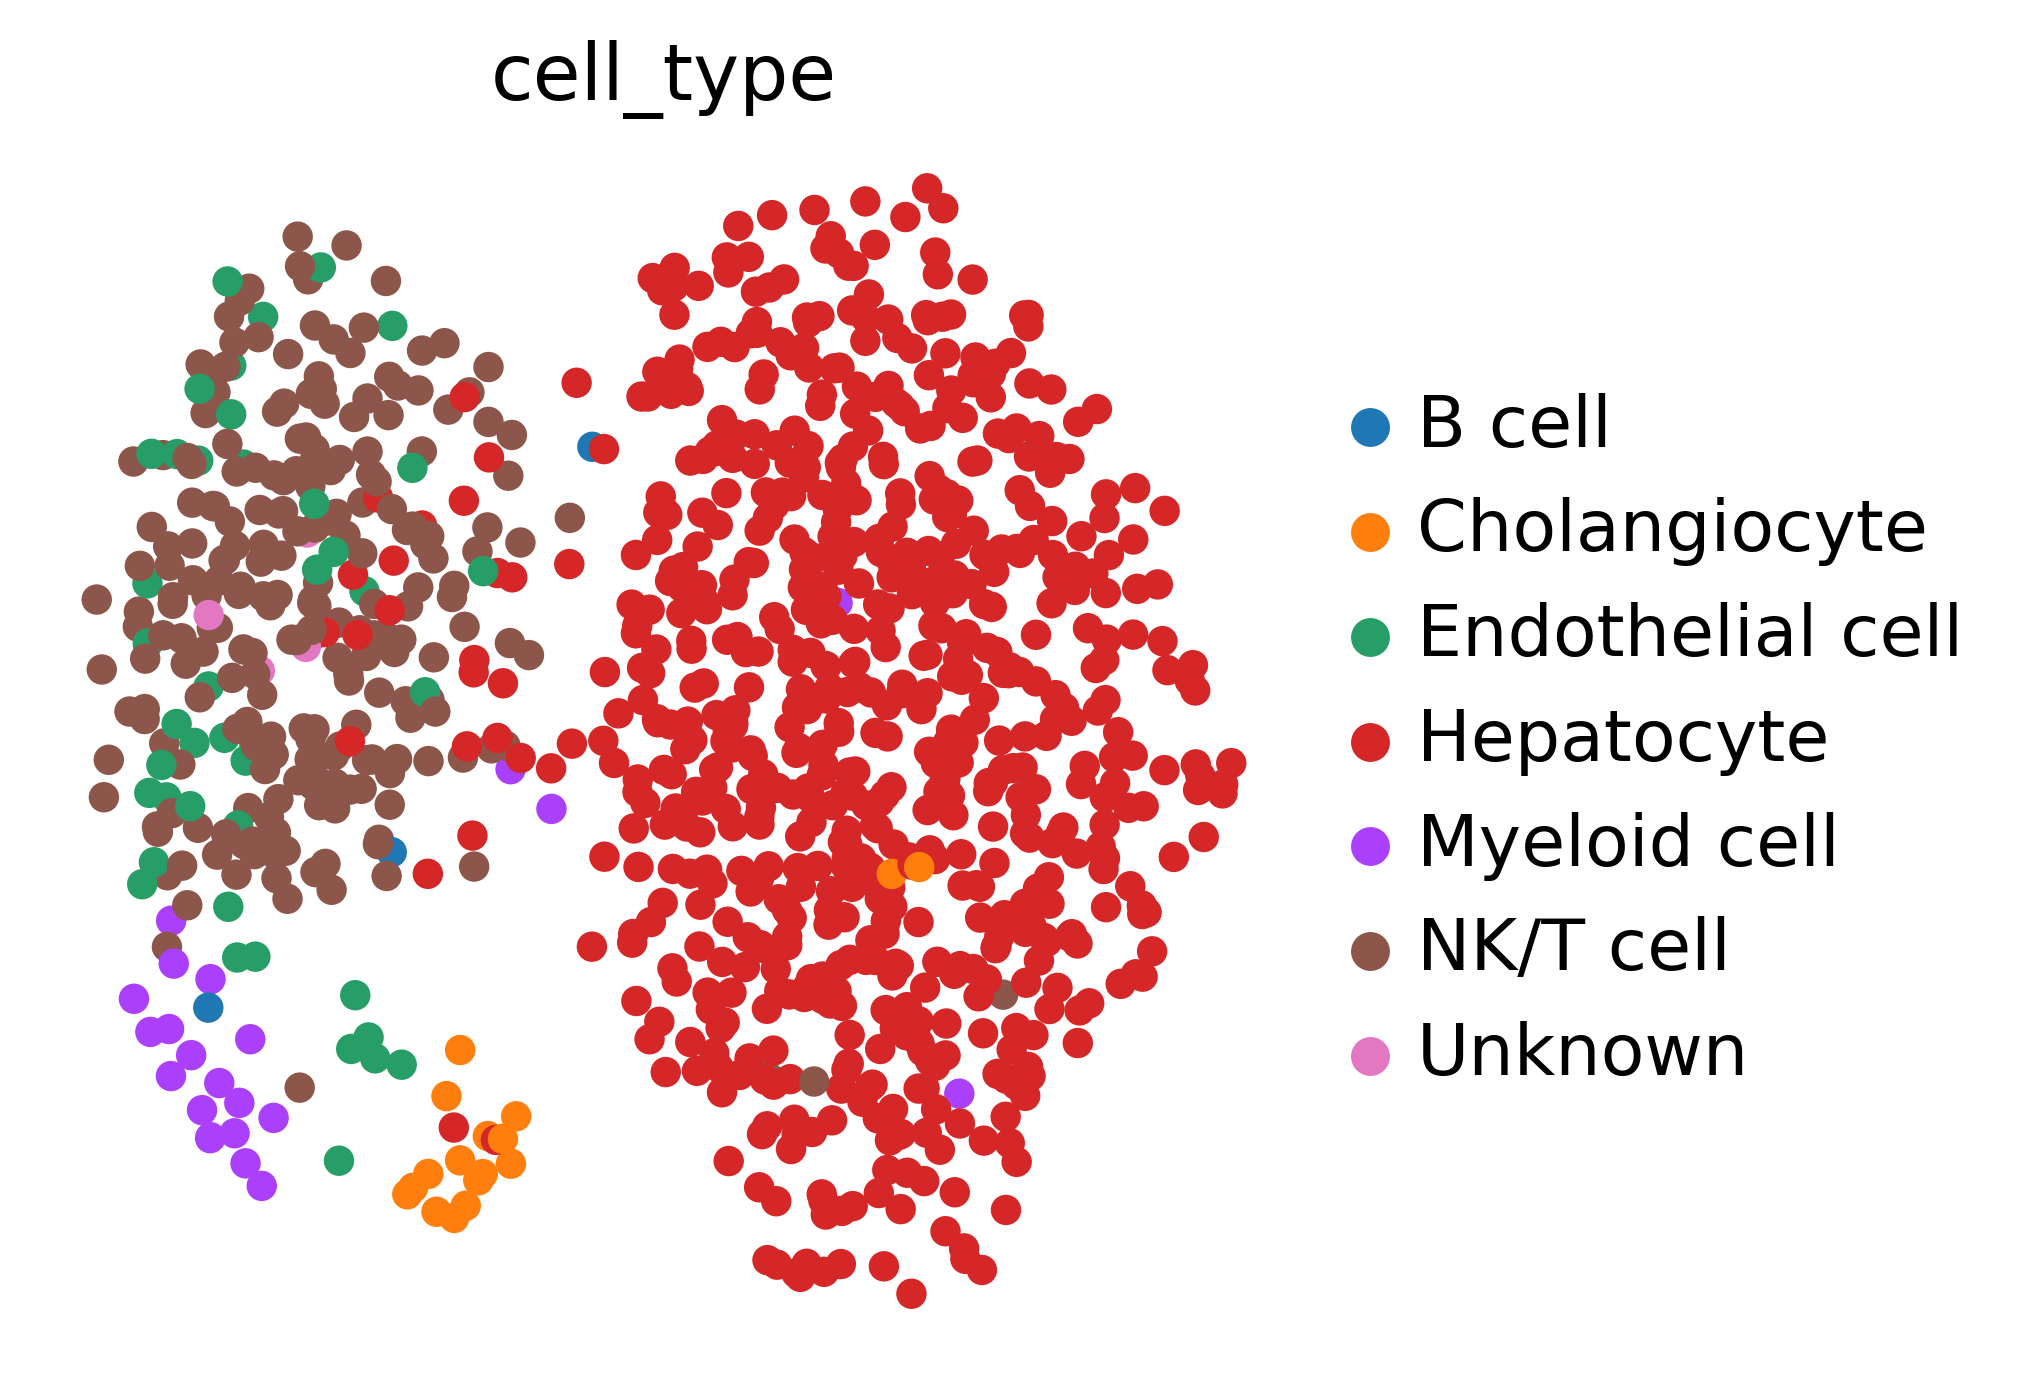

In [174]:
query_latent = sc.AnnData(inference_output['z'].cpu().detach().numpy())
# query_latent = sc.AnnData(exprs.numpy())
# sc.pp.pca(query_latent)

query_latent.obs["cell_type"] = query_adata[:n,:].obs["level1"].tolist()
sc.pp.neighbors(query_latent, n_neighbors=8)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
sc.pl.umap(query_latent,
           color=['cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [134]:
model.train(max_epochs=0, plan_kwargs=dict(weight_decay=0.0))
latent = model.get_latent_representation()[:10,:]
latent

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training: 0it [00:00, ?it/s]

/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


array([[ 6.44e-03, -6.78e-01, -2.00e-02, -5.02e-01, -1.23e+00,  8.82e-02,
         1.28e+00,  5.54e-01, -2.58e-02, -1.51e-01,  1.87e-02,  1.39e+00,
         7.25e-01,  5.62e-02,  1.51e-02,  1.77e-03, -4.50e-01, -2.18e+00,
        -7.02e-01,  4.07e-02, -1.75e-01,  3.23e-02,  7.55e-03,  6.52e-02,
        -4.01e-02, -1.24e-03, -1.01e-02, -1.72e-02, -9.39e-01, -1.54e-02],
       [-8.45e-02,  9.68e-02, -3.45e-02, -7.95e-01, -1.20e+00,  9.19e-02,
         4.40e-02, -4.82e-02, -1.23e-02, -1.34e+00,  4.25e-03,  1.24e+00,
         4.36e-01,  1.21e+00,  5.94e-02,  1.11e-01,  2.51e-01, -1.47e+00,
         9.22e-02, -6.61e-02,  4.13e-01,  3.49e-03,  7.77e-03,  1.39e+00,
         1.03e-01,  4.59e-03,  6.82e-02, -2.82e-02, -9.61e-01,  7.71e-03],
       [ 8.44e-03, -9.83e-01,  1.72e-02,  8.50e-01, -4.35e-01,  1.21e-01,
         1.19e+00,  1.83e+00, -1.05e-05, -4.54e-01,  3.01e-03,  7.96e-01,
         1.05e+00,  1.01e+00, -3.85e-02,  1.55e-02,  6.80e-01,  1.00e+00,
        -1.14e+00,  5.20e-02,  1.73e

In [46]:
dir(model.module)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_compute_local_library_params',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_generative_input',
 '_get_inference_input',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_

In [150]:
from scvi.distributions import NegativeBinomial
# n = 10
# generative_output = model.module.generative(
#     z=torch.rand(n, 30),
#     library=torch.full((n, 1), 1e3), 
#     batch_index=torch.full((n, 1), 3)
# )
generative_output = model.module.generative(
    z=inference_output['z'],
    library=inference_output['library'], 
    batch_index=torch.full((n, 1), 3)
)
generative_output

{'px_scale': tensor([[    0.000,     0.000,     0.001,     0.000,     0.001,     0.002,
              0.000,  ...,     0.003,     0.005,     0.008,     0.003,
              0.005,     0.001,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.000,     0.001,
              0.000,  ...,     0.011,     0.024,     0.028,     0.011,
              0.018,     0.000,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.000,     0.000,
              0.000,  ...,     0.019,     0.038,     0.048,     0.022,
              0.028,     0.000,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.000,     0.001,
              0.000,  ...,     0.012,     0.016,     0.023,     0.012,
              0.013,     0.000,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.006,     0.001,
              0.000,  ...,     0.014,     0.052,     0.060,     0.063,
              0.027,     0.001,     0.000],
         [    0.000,     0.000,  

In [151]:
dist = NegativeBinomial(mu=generative_output['px_rate'], 
                        theta=generative_output['px_r'])
exprs = dist.sample().cpu()
print(exprs.shape)
exprs
# n_samples = n
# if n_samples > 1:
#     exprs = dist.sample().permute(
#         [1, 2, 0]
#     )  # Shape : (n_cells_batch, n_genes, n_samples)
# else:
#     exprs = dist.sample()
# exprs 

torch.Size([500, 2000])


tensor([[  0.,   0.,   0.,   1.,   0.,   0.,   0.,  ...,   0.,   2.,   0.,   0.,
           1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   1.,   5.,   4.,   2.,
           1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   4.,  16.,   7.,  13.,
           4.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  ...,   2.,   3.,   3.,   1.,
           3.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   7.,   1.,   0.,  ...,  18.,  57., 107.,  65.,
          22.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,  ...,   0.,   2.,   0.,   1.,
           2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,  ...,   2.,   4.,   5.,   6.,
           1.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,  ...,  19.,  58.,  78.,  52.,
          20.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   5.,   1.,   1.,  ...,   4.,  17.,  33.,  19.,
          16.,   0.,   0.],
      

In [47]:
help(model.module.generative)

Help on method generative in module scvi.module._vae:

generative(z, library, batch_index, cont_covs=None, cat_covs=None, y=None, transform_batch=None) method of scvi.module._vae.VAE instance
    Runs the generative model.



In [167]:
train_set.layers['counts'][:n,:].toarray()

array([[  0.,   0.,   0.,   0.,   1.,   0.,   2., ...,  18.,  40.,  39.,
         24.,  19.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0.,   0., ...,  53.,  57.,  58.,
         39.,  34.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., ...,   5.,  10.,  14.,
          4.,   7.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., ...,   8.,  17.,  25.,
          3.,   9.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., ...,   2.,   1.,   9.,
          5.,   3.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., ...,  29.,  57.,  78.,
         44.,  59.,   0.,   0.],
       [  0.,   0.,   0.,   2.,  14.,   3.,   0., ...,   2.,   8.,   4.,
          5.,   5.,   2.,   3.],
       ...,
       [  0.,   0.,   0.,   2.,  22.,   3.,   0., ...,   0.,   0.,   7.,
          2.,   1.,   3.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., ...,   2.,   0.,   4.,
          1.,   1.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   

In [110]:
query_adata.X[:10,:].toarray()

array([[0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 4., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [44]:
from scipy.sparse import csr_matrix
query_adata = sc.read_h5ad("/home/wyh/liver_atlas/data/Aizarani2019/Aizarani2019_plot_V2.h5ad")
def feature_alignment(test_set, gene_list):
    test_set.X = test_set.layers['counts']
    
    # set test_set features as gene_list, zero-filling for missing features
    selected_set = set(gene_list)
    test_set_genes = set(test_set.var_names)
    common_set = selected_set & test_set_genes
    gene_extra = selected_set - common_set
    n_extra = len(gene_extra)
    if n_extra / len(gene_list) > 0.05:
        print("Warning: %d features not exist in testset." % len(gene_extra))

    if n_extra > 0:  # fill zeros for missing features
        new_mtx = csr_matrix(test_set.X, shape=(test_set.n_obs, test_set.n_vars + n_extra))
        test_adata = sc.AnnData(new_mtx)
        test_adata.obs = test_set.obs
        test_adata.layers['counts'] = test_adata.X
        test_adata.obs_names = test_set.obs_names
        test_adata.var_names = list(test_set.var_names) + list(gene_extra)
        # test_adata.obs = test_set.obs
        return test_adata[:, gene_list]
    else:
        return test_set[:, gene_list]
query_adata = feature_alignment(query_adata, list(train_set.var_names))

model = sca.models.SCVI.load_query_data(query_adata, 
                                reference_model = vae, freeze_dropout=True)
model.module

/tmp/ipykernel_887252/1655725600.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  test_adata = sc.AnnData(new_mtx)
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:95: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` 

INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 10372 cells, 2000 vars, 4 batches,
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 10372 cells, 2000 vars, 4 batches, 9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=2000, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): None
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=30, bias=True)
    (var_encoder): Linear(in_features=128, out_features=30, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=2000, out_features=128, bias=True)
          (1): None
          (2): LayerNorm(

In [120]:
inference_output['z'].cpu().detach().numpy()

array([[ 2.34e+00, -1.19e+00,  2.11e+00,  3.68e-01, -1.01e+00,  2.20e+00,
         1.23e+00,  3.83e-01,  1.03e+00,  9.25e-01, -1.31e+00,  1.44e+00,
         9.84e-01,  2.01e-01, -4.83e-01,  5.90e-02, -1.48e-01, -2.63e+00,
        -3.47e-01,  1.53e-01,  1.10e-01,  1.80e+00, -6.42e-02,  5.14e-02,
         3.15e-01, -1.35e-01, -5.09e-01,  5.22e-01, -1.49e+00, -5.19e-01],
       [-3.07e-01,  3.95e-01, -3.01e+00, -1.35e+00, -1.31e+00,  4.26e-01,
         3.67e-01, -1.77e-01, -8.88e-01, -1.43e+00, -1.81e-01,  4.96e-01,
         7.52e-01,  1.25e+00,  7.85e-01, -3.79e-01,  6.34e-01, -1.23e+00,
        -5.34e-02,  2.21e-01,  4.47e-01, -1.32e+00,  1.12e+00,  1.31e+00,
         1.68e+00, -1.06e+00, -9.29e-01,  2.50e+00, -1.14e+00,  2.55e-01],
       [ 5.07e-01, -9.48e-01, -6.52e-01,  5.62e-01, -4.80e-01, -1.27e+00,
         9.47e-01,  1.94e+00, -1.53e+00, -2.65e-02,  2.90e-01,  6.39e-01,
         9.64e-01,  8.85e-01,  8.76e-01,  5.83e-01,  9.28e-01,  1.04e+00,
        -7.78e-01, -9.51e-01,  1.36e

In [92]:
n

10372